### generic model for face detection (based on an object detection model)
### model
- `VGGIG` - predefined model for object detection
- input 
    - image [200 x 200]
- output 
    - [0,1] - 0 if face is not present on the image, 1 otherwise
    - x,y,w,h - coordinates of the face on the image
### dictionary
- bounding box - box that marks area where our object is present (in our case face)
### libraries 
- `labelme` - Library that contains method that we will use to label data


In [ ]:
from pathlib import Path # to get the path of the current file
import time # to measure time
import uuid # for unique id
import cv2
import os
import random

# collect data

In [ ]:
DATA_PATH = Path.cwd() / 'data'  # path to the data folder
IMAGES_NUMBER = 0
DATA_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
capture = cv2.VideoCapture(0) # 0 is the default camera
for num in range(IMAGES_NUMBER):
    print(f'Image {num}/{IMAGES_NUMBER}')
    ret, frame = capture.read()
    if ret:
        img_name = str(Path(DATA_PATH / 'images' / f'{uuid.uuid4()}.jpg').resolve())
        cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(.5) 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
capture.release()
#cv2.destroyAllWindows()

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
images = tf.data.Dataset.list_files(str(DATA_PATH /'*.jpg'))


In [4]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next().shape

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [ ]:
for folder in ['train','test','']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [50]:
import albumentations as alb

In [64]:
augmentor = alb.Compose([alb.RandomCrop(width=403, height=403), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)], 
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [75]:
image = cv2.imread(os.path.join('data','train','images','310649587_1218860985327644_2650208442576522227_n.jpg'))
image.shape

(403, 403, 3)

In [76]:
with open(os.path.join('data','train','labels','310649587_1218860985327644_2650208442576522227_n.json')) as f:
    label = json.load(f)
label['shapes'][0]['points']

[[5.656903765690373, 118.41004184100417],
 [144.98744769874475, 337.23849372384933]]

In [77]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [78]:
coords = list(np.divide(coords, [403, 403, 403, 403]))

In [79]:
augmented = augmentor(image=image, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[175, 225, 243],
         [173, 223, 241],
         [171, 221, 239],
         ...,
         [ 34,  36,  44],
         [ 16,  19,  27],
         [  0,   3,  11]],
 
        [[172, 222, 240],
         [171, 221, 239],
         [171, 221, 239],
         ...,
         [ 49,  51,  59],
         [ 35,  38,  46],
         [ 24,  27,  35]],
 
        [[171, 222, 238],
         [170, 221, 237],
         [170, 221, 237],
         ...,
         [ 48,  50,  58],
         [ 41,  44,  52],
         [ 36,  39,  47]],
 
        ...,
 
        [[210, 215, 216],
         [196, 201, 202],
         [171, 176, 177],
         ...,
         [163, 184, 185],
         [161, 182, 183],
         [159, 180, 181]],
 
        [[205, 210, 211],
         [193, 198, 199],
         [168, 172, 173],
         ...,
         [159, 180, 181],
         [157, 178, 179],
         [154, 175, 176]],
 
        [[199, 204, 205],
         [190, 195, 196],
         [163, 167, 168],
         ...,
         [161, 182,

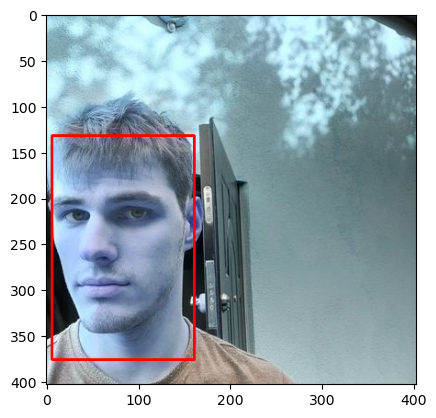

In [80]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [85]:
for partition in ['train','test']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [403, 403, 403, 403]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.9557191357704248, 0.7433786351319082, 0.6214063976245107, 0.26578900920917387, 'face'].
x_max is less than or equal to x_min for bbox [0.7335361358846308, 0.7932140743586283, 0.473976556578797, 0.33535097646313733, 'face'].


In [11]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [15]:
train_images